In [7]:
import numpy as np
import itertools
import cv2
import pywt
import os
import random
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Read train and validation images and returns numpy arrays (features and labels)
def read_images():
    
    train_data_path = 'RSSCN7'
    nb_classes = 7
    
    fourier_transform = []
    histogram_results = []
    haar_coefficients = []
    test_labels = []
    counter = 0
    for foldername in os.listdir(train_data_path):
        for filename in os.listdir(train_data_path + '\\' + foldername):    
            imagePath = train_data_path + '\\' + foldername + '\\' + filename
            
            image = cv2.imread(imagePath)
            
            ######################################################################
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # load the image data into a numpy array
            # perform the 2-D fast Fourier transform on the image data
            fourier = np.fft.fft2(gray)
            # move the zero-frequency component to the center of the Fourier spectrum
            fourier = np.fft.fftshift(fourier)
            # compute the magnitudes (absolute values) of the complex numbers
            fourier = np.abs(fourier)
            # compute the common logarithm of each value to reduce the dynamic range
            fourier = np.log10(fourier)
            fourier = fourier.flatten()
            
            ######################################################################
            chans = cv2.split(image)
            features = []
            colors = ("b", "g", "r")
            # loop over the image channels
            for (chan, color) in zip(chans, colors):
                # create a histogram for the current channel and
                # concatenate the resulting histograms for each
                # channel
                hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
                features.extend(hist)
            
            histogram = np.array(features).flatten()

            ######################################################################
            flattenImg = image.flatten()
            (ca, cd) = pywt.dwt(flattenImg,'haar')
            #haar = np.concatenate((ca, cd), axis=0)
            
            fourier_transform.append(fourier)
            histogram_results.append(histogram)
            haar_coefficients.append(cd)
            
            test_labels.append(counter)

        counter += 1

    fourier_arr = np.stack(fourier_transform)
    histogram_arr = np.stack(histogram_results)
    haar_arr = np.stack(haar_coefficients)
    
    train_y = np.stack(test_labels)
    
    return (train_y, fourier_arr, histogram_arr, haar_arr)

In [4]:
# Get features and labels as numpy arrays 
(Y, FOURIER, HISTOGRAM, HAAR) = read_images()
# Print information about datas
print(len(Y), len(FOURIER), len(HISTOGRAM), len(HAAR))

# Apply lda to feature vectors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

haarFeatures = lda.fit_transform(HAAR,Y)
print('HAAR OK')
histogramFeatures = lda.fit_transform(HISTOGRAM,Y)
print('HISTOGRAM OK')
fourierFeatures = lda.fit_transform(FOURIER,Y)
print('FOURIER OK')

2800 2800 2800 2800


C:\Users\ferdol\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\ferdol\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


HAAR OK
HISTOGRAM OK
FOURIER OK


In [5]:
# Feature vector
X = []
for i in range(2800):
    X.append([fourierFeatures[i], histogramFeatures[i], haarFeatures[i]])

for i in range(2800):
    X[i] = np.asarray(X[i]).flatten()
    
X = np.asarray(X)

Confusion matrix, without normalization


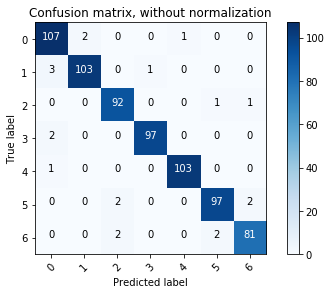

Confusion matrix, without normalization


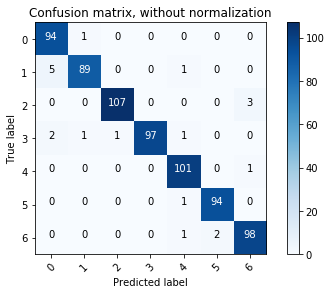

Confusion matrix, without normalization


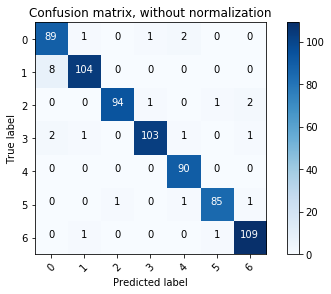

Confusion matrix, without normalization


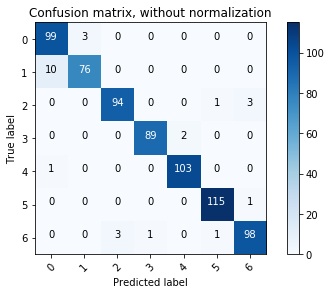

Normalized confusion matrix


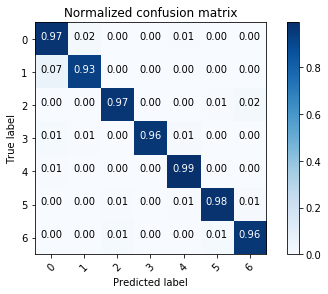

Confusion matrix, without normalization


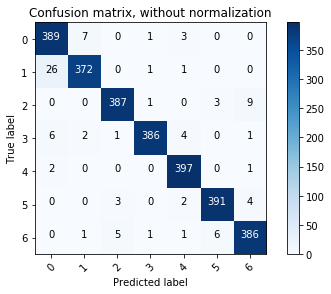

Accuracy : %96


In [8]:
#Calssification section KNN(n=5) k-fold(n=4)
knn = KNeighborsClassifier(n_neighbors=5)

data_size = 2800

# Suffle train data and train labels
combined = list(zip(X, Y))
random.shuffle(combined)
X, Y = zip(*combined)

kf = KFold(n_splits=4)

total_matrix = None
flag = False
for train, test in kf.split(X):

    Xtrain_data = np.array(X)[train]
    Xtest_data = np.array(X)[test]

    Ytrain_data = np.array(Y)[train]
    Ytest_data = np.array(Y)[test]
    
    knn.fit(Xtrain_data, Ytrain_data)
    predicted = knn.predict(Xtest_data)

    cnf_matrix = confusion_matrix(y_true=Ytest_data, y_pred=predicted, labels=np.unique(Y))
    cnf_matrix.resize(np.unique(Y).shape[0], np.unique(Y).shape[0])
    if(flag == False):
        total_matrix = cnf_matrix
        flag = True
    else:
        total_matrix += cnf_matrix
        
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=np.unique(Y), title='Confusion matrix, without normalization')
    plt.show()

plt.figure()
plot_confusion_matrix(total_matrix, classes=np.unique(Y), title='Normalized confusion matrix', normalize=True)
plt.show()

plt.figure()
plot_confusion_matrix(total_matrix, classes=np.unique(Y), title='Confusion matrix, without normalization')
plt.show()

total = 0
for i in range(total_matrix.shape[0]):
    total += total_matrix[i][i]

print("Accuracy : %" + str((total*100)//data_size))